# Task 0: Introduction

Welcome to this Kaggle notebook, where we explore building a deep learning model for image classification on the CIFAR-10 dataset. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes, providing a challenging yet rewarding opportunity to work with small image classification tasks. In this notebook, we take a step-by-step approach to load and preprocess the data, build a Convolutional Neural Network (CNN) using TensorFlow/Keras, train it with data augmentation techniques to enhance model generalization, and evaluate its performance. The goal is to achieve an optimized and robust model capable of accurately predicting labels for unseen images, ultimately submitting our predictions to Kaggle for evaluation.

# Task 1: Importing Libraries

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [2]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 17.8 MB/s eta 0:00:00


In [3]:
# Standard Libraries
import os

# Data Manipulation and Processing
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import py7zr  # For handling 7z files
import matplotlib.pyplot as plt

# TensorFlow Keras Utilities and Layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Flatten,
    Dropout,
    InputLayer,
    GlobalAveragePooling2D,
    RandomFlip,
    BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Selection
from sklearn.model_selection import train_test_split

# Task 2: Loading the Dataset

In [4]:
# Define file paths
train_labels_path = "/kaggle/input/cifar-10/trainLabels.csv"
sample_submission_path = "/kaggle/input/cifar-10/sampleSubmission.csv"
train_zip_path = "/kaggle/input/cifar-10/train.7z"
test_zip_path = "/kaggle/input/cifar-10/test.7z"
main_extracted_path = "/kaggle/working/"
extracted_train_path = "/kaggle/working/train"
extracted_test_path = "/kaggle/working/test"

# Extract 7z files
def extract_7z(file_path: str, output_dir: str) -> None:
    """Extracts 7z files into the specified directory."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    with py7zr.SevenZipFile(file_path, mode='r') as z:
        z.extractall(path=output_dir)

extract_7z(train_zip_path, main_extracted_path)
extract_7z(test_zip_path, main_extracted_path)

# Task 3: Data Preprocessing

In [5]:
# Load Train Labels
train_labels = pd.read_csv(train_labels_path)
train_labels["id"] = train_labels["id"].astype(str) + ".png"  # Add .png extension to image IDs

# Helper Function to Load Images
def load_images(data_path: str, labels: pd.DataFrame = None) -> tuple[np.ndarray, np.ndarray]:
    """Loads images and corresponding labels from a directory."""
    images, labels_list = [], []
    
    for _, row in tqdm(labels.iterrows(), total=labels.shape[0], desc="Loading Train Images"):
        img_path = os.path.join(data_path, row["id"])
        image = cv2.imread(img_path)

        # Check if the image is loaded successfully
        if image is not None:
            image = cv2.resize(image, (32, 32))  # Resize to CIFAR-10 standard size
            images.append(image)
            labels_list.append(row["label"])
        else:
            print(f"[WARNING] Unable to load image at path: {img_path}")
    
    return np.array(images, dtype=np.float32) / 255.0, pd.factorize(labels_list)[0]

# Load and Preprocess Train Images and Labels
train_images, train_labels = load_images(extracted_train_path, train_labels)

# One-hot Encode Labels
train_labels = to_categorical(train_labels)

# Train-Validation Split
trainX, valX, trainY, valY = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Load Test Images
def load_test_images(data_path: str) -> np.ndarray:
    """Loads test images from the directory."""
    test_ids = [f for f in os.listdir(data_path) if f.endswith(".png")]
    test_images = [
        cv2.resize(cv2.imread(os.path.join(data_path, test_id)), (32, 32))
        for test_id in tqdm(test_ids, desc="Loading Test Images")
    ]
    return np.array(test_images, dtype=np.float32) / 255.0

# Load and Preprocess Test Images
testX = load_test_images(extracted_test_path)

# Summary
print(f"Train data shape: {trainX.shape}")
print(f"Validation data shape: {valX.shape}")
print(f"Test data shape: {testX.shape}")

Loading Train Images: 100%|██████████| 50000/50000 [00:11<00:00, 4495.64it/s]
/tmp/ipykernel_30/2825121012.py:22: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return np.array(images, dtype=np.float32) / 255.0, pd.factorize(labels_list)[0]
Loading Test Images: 100%|██████████| 300000/300000 [00:36<00:00, 8172.44it/s]


Train data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
Test data shape: (300000, 32, 32, 3)


# Task 4: Setting up Data Augmentation

In [6]:
# Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=(0.7, 1.3),
)

data_gen.fit(trainX)

# Return datasets
train_data = (trainX, trainY)
val_data = (valX, valY)
test_data = testX

# Task 5: Building the Neural Network Model

In [7]:
def get_model() -> Sequential:
    l2_reg = 0.001  # L2 regularization factor
    
    model = Sequential([
        InputLayer(input_shape=(32, 32, 3)),
        
        # Convolutional Block 1
        Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=L2(l2_reg)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=L2(l2_reg)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Convolutional Block 2
        Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=L2(l2_reg)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=L2(l2_reg)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Convolutional Block 3
        Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=L2(l2_reg)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=L2(l2_reg)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.35),

        # Fully Connected Layers
        Flatten(),
        Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=L2(l2_reg)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(10, activation='softmax', kernel_regularizer=L2(l2_reg))  # Output layer for 10 classes with L2 regularization
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Task 6: Training the Model

In [8]:
def train_model():
    BATCH_SIZE = 128
    (train_x, train_y), (val_x, val_y) = train_data, val_data

    model = get_model()
    
    # Flow Training Data with Augmentation
    train_iterator = data_gen.flow(train_x, train_y, batch_size=BATCH_SIZE)

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=0.01,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    # Model Training
    history = model.fit(
        train_iterator,
        steps_per_epoch=len(train_x) // BATCH_SIZE,
        epochs=5,
        validation_data=(val_x, val_y),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return model, history

In [9]:
model, history = train_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


312/312 ━━━━━━━━━━━━━━━━━━━━ 210s 651ms/step - accuracy: 0.2856 - loss: 3.4151 - val_accuracy: 0.2912 - val_loss: 3.1729 - learning_rate: 0.0010
Epoch 2/5
  1/312 ━━━━━━━━━━━━━━━━━━━━ 2:42 523ms/step - accuracy: 0.4062 - loss: 2.7039

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.4062 - loss: 2.7039 - val_accuracy: 0.2943 - val_loss: 3.1540 - learning_rate: 0.0010
Epoch 3/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 194s 619ms/step - accuracy: 0.4459 - loss: 2.5744 - val_accuracy: 0.5326 - val_loss: 2.2159 - learning_rate: 0.0010
Epoch 4/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.4922 - loss: 2.2838 - val_accuracy: 0.5314 - val_loss: 2.2210 - learning_rate: 0.0010
Epoch 5/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 193s 618ms/step - accuracy: 0.5323 - loss: 2.1703 - val_accuracy: 0.5529 - val_loss: 2.0264 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


# Task 7: Plotting Accuracy and Loss

In [10]:
def plot_training_history(history) -> None:
    """Plots the training history for accuracy and loss."""
    
    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy', linestyle='-', color='b')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', color='r')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(visible=True)

    # Plot Loss
    ax2.plot(history.history['loss'], label='Train Loss', linestyle='-', color='b')
    ax2.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', color='r')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(visible=True)

    # Improve Layout
    plt.tight_layout()
    plt.show()

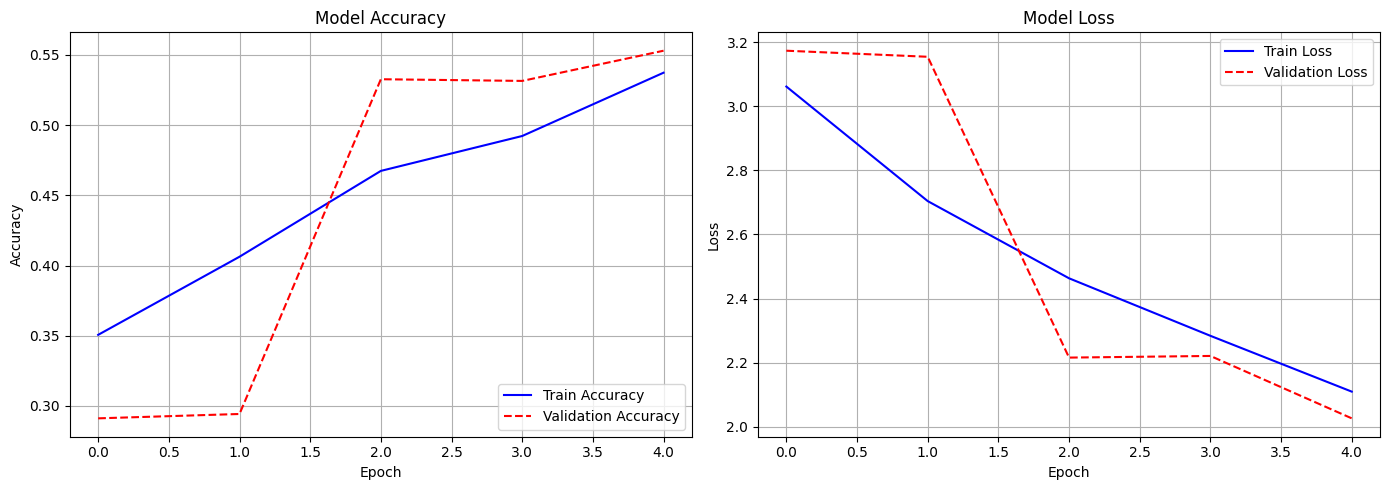

In [11]:
plot_training_history(history)

# Task 8: Making Predictions

In [12]:
def create_submission_file(model, test_data: np.ndarray, sample_submission_path: str, output_file: str = "submission.csv") -> None:
    """
    Makes predictions on test data and creates a submission file.

    Args:
    - model: Trained model to use for predictions.
    - test_data (np.ndarray): Preprocessed test dataset.
    - sample_submission_path (str): Path to the sample submission file.
    - output_file (str): Filename for the output CSV submission file.
    """
    # Define class labels corresponding to CIFAR-10 classes
    class_labels = [
        "airplane", "automobile", "bird", "cat", "deer",
        "dog", "frog", "horse", "ship", "truck"
    ]
    
    # Make Predictions
    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)  # Get class index with highest probability

    # Convert numerical predictions to class labels
    predicted_classes = [class_labels[idx] for idx in predicted_indices]
    
    # Load Sample Submission
    submission = pd.read_csv(sample_submission_path)

    # Assign Predictions
    submission['label'] = predicted_classes

    # Save Submission File
    submission.to_csv(output_file, index=False)
    print(f"Submission file saved to {output_file}")

# Example usage
create_submission_file(model, test_data=test_data, sample_submission_path=sample_submission_path)

9375/9375 ━━━━━━━━━━━━━━━━━━━━ 350s 37ms/step
Submission file saved to submission.csv
